# Text classification

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

# Binary classification

Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

# IMDB Movie reviews sentiment classification

We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

import copy
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb, reuters
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence

In [3]:
# this requires download for the first time
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = 10000, # top most frequent word to consider
                                                      skip_top = 0, # top most frequent word to ignore
                                                      maxlen = None, # maximum sequence length
                                                      seed = 113, # seed to reproducible data shuffling
                                                      start_char = 1, # the start of the sequence will makred with this character
                                                      oov_char = 2, # word that were cut off because of the num words and skip top
                                                      index_from = 3) # index actual word with this index and higher

The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `X_train` and `X_test` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`y_train` and `y_test` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [4]:
#############################################################################
# TODO: Print the first instance of training data in X_train                #
#############################################################################
print(X_train[0])
print(type(X_train[0]))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<class 'list'>


In [5]:
#############################################################################
# TODO: Print the first 10 labels in y_train                                #
#############################################################################
for i in range(10):
    print(y_train[i])
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

1
0
0
1
0
0
1
0
1
0


### Try to loop through some samples to see the length of the reviews before applying the proprocessing step:

In [6]:
#############################################################################
# TODO: Print the length of the first 10 instance in X_train                #
#############################################################################
for i in range(10):
    print(len(X_train[i]))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

218
189
141
550
147
43
123
562
233
130


Since we retricted to the top 10000 most frequent words, no word index will exceed 10000:

In [7]:
max([max(seq) for seq in X_train])

9999

## Restore word from index

In [8]:
# this requires download for the first time
word2index = imdb.get_word_index()
# reverse it, mapping integer to word
#############################################################################
# TODO: Reverse word2index, mapping integer to word. And store it into a    #
# dictionary called index2word                                              #
# Hine: use dict comprehension and items method in dict                     #
#############################################################################
index2word = {v: k for k, v in word2index.items()}
print(type(index2word))
print(len(index2word))
# print(inv_word2index)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

review_1 = ' '.join([index2word.get(i, '?') for i in X_train[0]])
print(review_1)

<class 'dict'>
88584
the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [9]:
for i in [0, 1, 2]:
    print(index2word.get(i, '?'))
    
#############################################################################
# TODO: You should add 3 to the value for every key before reversing        #
# since there are 3 special word <PAD> : 0, <START> : 1, and <UNK> : 2      #
# And then insert 3 entries to specify those special words as keys and      #
# their corresponding value                                                 #
# Reverse word2index, mapping integer to word. And store it into a          #
# dictionary called index2word                                              #
# Hine: use dict comprehension and items method in dict                     #
#############################################################################
index2word = {v+3: k for k, v in word2index.items()}
index2word[0] = "<PAD>"
index2word[1] = "<START>"
index2word[2] = "<UNK>"

    
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

?
the
and


In [10]:
review_1 = ' '.join(index2word.get(i, '?') for i in X_train[0])
print(review_1)
print(word2index['the'])
# print(word2index['<START>'])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* pad the list so that they all have the same length, and turn them into an integertensor of shape `(samples, word_indices)`, then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding`) layer.
* one-hot encoding the lists to turn them into vectors of 0s and 1s.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [11]:
def vectorize_sequences(sequences, dimension = 10000):
#############################################################################
# TODO: sequences is a list of instances, each instance contains a list of  #
# integers. vectorize_sequences will one-hot encoding the lists to turn     #
# them into vectors of 0s and 1s, indicating whether a word appeared in     #
# instance.                                                                 #
# results will have the dimension of (number of samples, dimension)         #
#############################################################################
    arr = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        for j in seq:
            arr[i][j] = 1
    results = arr
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################
    return results

# vectorized training data
X_train_vec = vectorize_sequences(X_train)
# vectorized test data
X_test_vec = vectorize_sequences(X_test)

In [12]:
X_train_vec.shape, X_test_vec.shape

((25000, 10000), (25000, 10000))

Here's what our samples look like now:

In [13]:
X_train_vec[0][:20]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1.])

We should also vectorize our labels, which is straightforward

In [14]:
y_train_vec = np.asarray(y_train).astype('float32')
y_test_vec = np.asarray(y_test).astype('float32')

Now our data is ready to be fed into a neural network.

## Build the network

Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [15]:
#############################################################################
# TODO: Build a model corresponding the above instructions or build your    #
# own model!                                                                #
#############################################################################
dimension_ = 10000
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (dimension_, )))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'relu'))

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `adam` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [17]:
#############################################################################
# TODO: Change any parameters if you desire                                 #
#############################################################################
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

## Validating the approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [18]:
#############################################################################
# TODO: Change the number of validation if you desire                       #
#############################################################################
X_val = X_train_vec[: 10000]
partial_X_train = X_train_vec[10000 :]

y_val = y_train_vec[: 10000]
partial_y_train = y_train_vec[10000 :]
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

We will now train our model for 20 epochs (20 iterations over all samples in the `partial_X_train` and `partual_y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [19]:
#############################################################################
# TODO: Change any parameter if you desire                                  #
#############################################################################
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    epochs = 20, 
                    batch_size = 512, 
                    validation_data = (X_val, y_val))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 153us/step - loss: 1.2325 - acc: 0.5400 - val_loss: 0.7415 - val_acc: 0.5539
Epoch 2/20
15000/15000 [==============================] - 2s 131us/step - loss: 0.6325 - acc: 0.6481 - val_loss: 0.5937 - val_acc: 0.6710
Epoch 3/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4651 - acc: 0.7612 - val_loss: 0.4839 - val_acc: 0.7748
Epoch 4/20
15000/15000 [==============================] - 2s 144us/step - loss: 0.3218 - acc: 0.8295 - val_loss: 0.4623 - val_acc: 0.8084
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.2349 - acc: 0.8472 - val_loss: 0.4927 - val_acc: 0.7924
Epoch 6/20
15000/15000 [==============================] - 2s 147us/step - loss: 0.1879 - acc: 0.8463 - val_loss: 0.5525 - val_acc: 0.7695
Epoch 7/20
15000/15000 [==============================] - 2s 145us/step - loss: 0.1548 - acc: 0.8286 - val_loss: 0.6323 - 

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

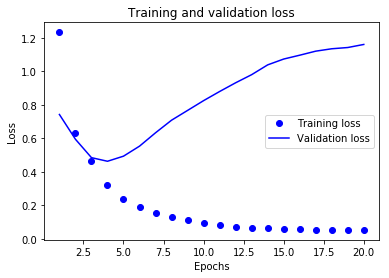

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

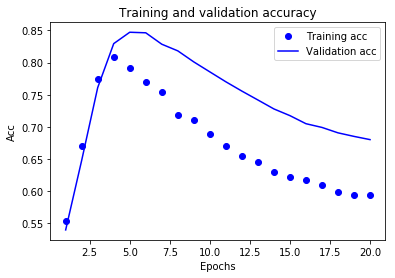

In [22]:
plt.clf() # clear figure

acc = history.history['val_acc']
val_acc = history.history['acc']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can 
leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [23]:
#############################################################################
# TODO: Redefine your model, compile it, fit it, evaluate it, and store the #
# result in results                                                         #
#############################################################################

dimension_ = 10000
model = models.Sequential()
model.add(layers.Dense(160, activation = 'selu', input_shape = (dimension_, )))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(250, activation = 'selu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1000, activation = 'selu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(160, activation = 'selu'))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

history = model.fit(partial_X_train, 
                    partial_y_train, 
                    epochs = 20, 
                    batch_size = 512, 
                    validation_data = (X_val, y_val))

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 160)               1600160   
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               40250     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              251000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 160)               160160    
__________

In [25]:
results = model.evaluate(X_test_vec, y_test_vec)
print(results)

25000/25000 [==============================] - 7s 266us/step
[0.44981776723861694, 0.8748]


Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches [Learned in Translation: Contextualized Word Vectors](https://arxiv.org/abs/1708.00107), one should be able to get close to 95%. Its implementation of the paper is at [CoVe](https://github.com/salesforce/cove) and 
written in [Pytorch](https://pytorch.org/) and its .

## Future experiment

* We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
* Try to use the `mse` loss function instead of `binary_crossentropy`.
* Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be 
improved!

## Conclusions

Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.

# Multi-class classification

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

# Reuter-21578 Data set

We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [85]:
# this requires download from the first time
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = 10000, 
                                                         skip_top = 0, 
                                                         maxlen = None,
                                                         seed = 113,
                                                         start_char = 1, 
                                                         oov_char = 2, 
                                                         index_from = 3)

2113536/2110848 [==============================] - 14s 6us/step


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [86]:
len(X_train), len(X_test)

(8982, 2246)

As with the IMDB reviews, each example is a list of integers (word indices):

In [88]:
#############################################################################
# TODO: Print the first instance of training data in X_train                #
#############################################################################
# print(X_train[0])
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Here's how you can decode it back to words, in case you are curious:

In [ ]:
# thie requires for the first time
word2index = reuters.get_word_index()
#############################################################################
# TODO: You should add 3 to the value for every key before reversing        #
# since there are 3 special word <PAD> : 0, <START> : 1, and <UNK> : 2      #
# And then insert 3 entries to specify those special words as keys and      #
# their corresponding value                                                 #
# Reverse word2index, mapping integer to word. And store it into a          #
# dictionary called index2word                                              #
# Hine: use dict comprehension and items method in dict                     #
#############################################################################
pass
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

newswire_1 = ' '.join([index2word.get(i, '?') for i in X_train[0]])
print(newswire_1)

The label associated with an example is an integer between 0 and 45: a topic index.

In [ ]:
y_train[0]

## Prepare the data

We can vectorize the data with the exact same code as in our previous example:

In [ ]:
X_train_vec = vectorize_sequences(X_train)
X_test_vec = vectorize_sequences(X_test)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [ ]:
def to_one_hot(labels, dimension = 46):
#############################################################################
# TODO: labels is a list of integer, to_one_hot will change the list of     #
# categorical variables into an sparse matrix where each column corresponds #
# to one possible label                                                     #
# results will have the dimension of (number of samples, dimension)         #
#############################################################################
    pass
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################
    return results

one_hot_y_train = to_one_hot(y_train)
one_hot_y_test = to_one_hot(y_test)

# Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:
# one_hot_y_train = to_categorical(y_train)
# one_hot_y_test = to_categorical(y_test)

## Build the network

This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [ ]:
#############################################################################
# TODO: Build a model corresponding the above instructions or build your    #
# own model!                                                                #
#############################################################################
pass
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [ ]:
#############################################################################
# TODO: Change any parameters if you desire                                 #
#############################################################################
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

## Validating the approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [ ]:
#############################################################################
# TODO: Change the number of validation if you desire                       #
#############################################################################
X_val = X_train_vec[: 1000]
partial_X_train = X_train_vec[1000 :]

y_val = one_hot_y_train[: 1000]
partial_y_train = one_hot_y_train[1000 :]
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

Now let's train our network for 20 epochs:

In [ ]:
#############################################################################
# TODO: Change any parameter if you desire                                  #
#############################################################################
history = model.fit(partial_X_train, 
                    partial_y_train, 
                    epochs = 20, 
                    batch_size = 512, 
                    validation_data = (X_val, y_val))
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [ ]:
#############################################################################
# TODO: Redefine your model, compile it, fit it, evaluate it, and store the #
# result in results                                                         #
#############################################################################
pass
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

In [ ]:
results

Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [ ]:
y_test_copy = copy.copy(y_test)
np.random.shuffle(y_test_copy)
float(np.sum(np.array(y_test) == np.array(y_test_copy))) / len(y_test)

## A different way to handke the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor.

The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently karge intermediate layers

We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
model.fit(partial_X_train, 
          partial_y_train, 
          epochs = 20, 
          batch_size = 512, 
          validation_data = (X_val, y_val))

Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.